In [1]:
import os
import time
import numpy as np

import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import Polygon

import sliderule
from sliderule import icesat2, gedi, earthdata

import matplotlib.pyplot as plt




In [2]:
# dir(gedi.gedi04ap)
# ?gedi.gedi04ap

In [3]:
earthdata.set_max_resources(8000000)

In [4]:
# Read shp with the fishnet
# Each square is the roi for one iteration
tiles_path = '/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/atlantic_forest/tiles/br_af_grid90km_prj.gpkg' 
# tiles_path = '/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/atlantic_forest/tiles/br_af_grid30km_prj.gpkg' 

tiles_gdf = gpd.read_file(tiles_path)



In [5]:
tiles_gdf_wgs84 = tiles_gdf.to_crs('EPSG:4326')

In [11]:
import folium
# m = folium.Map(location=[tiles_gdf_wgs84.geometry.centroid.y.mean(),
#                          tiles_gdf_wgs84.geometry.centroid.x.mean()],
#                zoom_start=8, tiles="cartodbpositron")

# # Add polygons with tile_num as tooltip
# for _, row in tiles_gdf_wgs84.iterrows():
#     sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
#     geo_j = sim_geo.to_json()
#     folium.GeoJson(
#         data=geo_j,
#         style_function=lambda x: {"fillColor": "transparent", "color": "blue", "weight": 1},
#         tooltip=folium.Tooltip(f"Tile: {row['tile_num']}")
#     ).add_to(m)

# # Save or display
# m


# Create map centered on your data
m = folium.Map(location=[tiles_gdf_wgs84.geometry.centroid.y.mean(),
                         tiles_gdf_wgs84.geometry.centroid.x.mean()],
               zoom_start=8, tiles=None)

# Add imagery basemap
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Satellite",
    overlay=False,
    control=True
).add_to(m)

# Add polygons with tile_num as tooltip
for _, row in tiles_gdf_wgs84.iterrows():
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    folium.GeoJson(
        data=geo_j,
        style_function=lambda x: {"fillColor": "transparent", "color": "red", "weight": 1},
        tooltip=folium.Tooltip(f"Tile: {row['tile_num']}")
    ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)


m

/tmp/ipykernel_380/2992715616.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[tiles_gdf_wgs84.geometry.centroid.y.mean(),
/tmp/ipykernel_380/2992715616.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tiles_gdf_wgs84.geometry.centroid.x.mean()],


In [6]:
# FOCAL_TILE = [4]
FOCAL_TILE = [89]
# FOCAL_TILE = [99]

# FOCAL_TILE = list(range(4))

tile = tiles_gdf_wgs84[tiles_gdf_wgs84['tile_num'].isin(FOCAL_TILE) ]


In [7]:
tile_temp_fn = '/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/gedi/test/temp2.gpkg'
tile.to_file(tile_temp_fn)

In [102]:
# FOCAL_TILE

In [103]:
bbox_df = tile.geometry.bounds.iloc[0]
minx, miny, maxx, maxy = bbox_df['minx'], bbox_df['miny'], bbox_df['maxx'], bbox_df['maxy']
bbox_polygon = box(minx, miny, maxx, maxy)


In [104]:
bbox_gdf = gpd.GeoDataFrame({"id": [1]}, geometry=[bbox_polygon], crs=tile.crs)


In [105]:
# region_sliderule = sliderule.toregion(tile)
region_sliderule = sliderule.toregion(bbox_gdf)


In [106]:
# region_sliderule['poly']

In [107]:
parms = {
    "poly": region_sliderule['poly'],
    "degrade_flag": 0,
    "l4_quality_flag": 1,
    'l2_quality_flag': 1
    # "beam": 0 #"beam": -1 # "-1" means all beams
}

In [108]:
gedi.init()

In [109]:
%%time
# Request GEDI Data
print('Requesting GEDI data')
gedi04a = gedi.gedi04ap(parms, keep_id = True)

print("Received {} footprints".format(gedi04a.shape[0]))
if len(gedi04a) > 0:
    print("Beams: {}".format(gedi04a["beam"].unique()))

Requesting GEDI data
Received 56312 footprints
Beams: [ 2  3  0  1  5  6  8 11]
CPU times: user 925 ms, sys: 12.1 ms, total: 937 ms
Wall time: 14.1 s


In [87]:
# gedi04a.crs
# Notes

# Run with maximium 1 tile 90 km

# Tile 4 30 km
# Received 56312 footprints 

# Tile 99 90 km
# Received 446176 footprints

# tile 89 90 km
# 444231 footprints


# 1 tile, focal_tile 4 90 km
# Received 841814 footprints
# 1 tile 90 km
#24.7 s
# Received 510544 footprints
# Received 510544 footprints
# Received 510544 footprints

# 2 tiles 90 km
# Received 510544 footprints
# Received 506352 footprints
# Received 509687 footprints
# Why getting different numbers at each run?
# Trying with simpler geometry:
# Received 520550 footprints
# Received 520550 footprints

# 4 tiles 90 km
# Received 520550 footprints
# Received 520550 footprints

In [88]:
gedi04a_wgs84 = gedi04a.to_crs('EPSG:4326')

In [89]:
gedi04a_wgs84['year'] = gedi04a_wgs84.index.year
gedi04a_wgs84['month'] = gedi04a_wgs84.index.month

In [90]:
output_gedi_fn = f'/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/gedi/test/l4a_t90km_t{FOCAL_TILE[0]}.gpkg'
gedi04a_wgs84.to_file(output_gedi_fn)

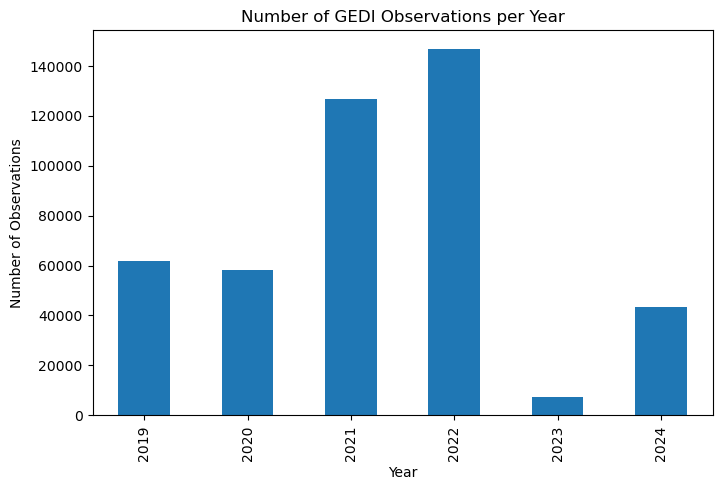

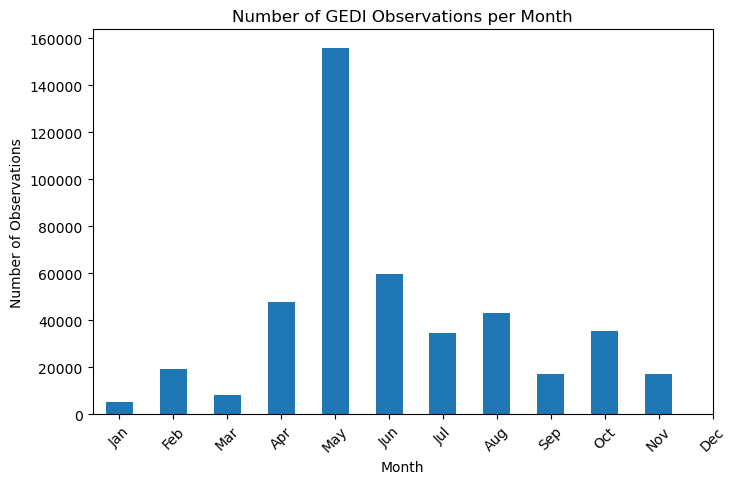

In [91]:
# Count observations per year
year_counts = gedi04a_wgs84['year'].value_counts().sort_index()

# Count observations per month (aggregated across all years)
month_counts = gedi04a_wgs84['month'].value_counts().sort_index()

# Plot number of observations per year
plt.figure(figsize=(8,5))
year_counts.plot(kind='bar')
plt.title("Number of GEDI Observations per Year")
plt.xlabel("Year")
plt.ylabel("Number of Observations")
plt.show()

# Plot number of observations per month
plt.figure(figsize=(8,5))
month_counts.plot(kind='bar')
plt.title("Number of GEDI Observations per Month")
plt.xlabel("Month")
plt.ylabel("Number of Observations")
plt.xticks(range(0,12), 
           ['Jan','Feb','Mar','Apr','May','Jun',
            'Jul','Aug','Sep','Oct','Nov','Dec'],
           rotation=45)
plt.show()


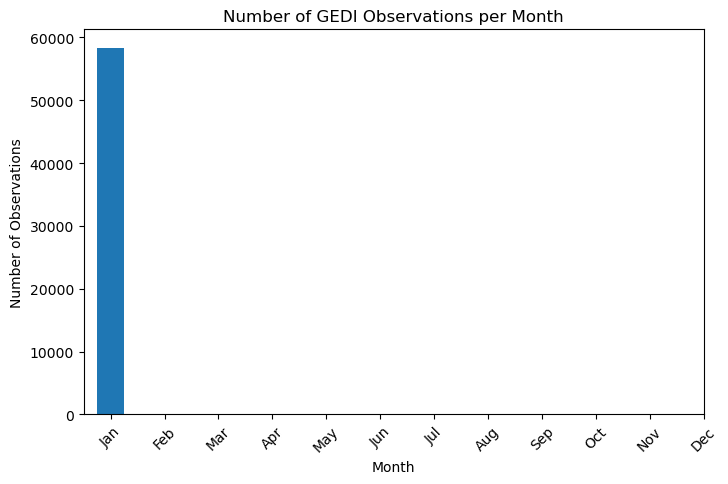

In [92]:
# Plot by month for specific year

year = 2020

gedi04a_wgs84_yeari = gedi04a_wgs84[gedi04a_wgs84['year'] == year]

# Count observations per month (aggregated across all years)
month_counts = gedi04a_wgs84_yeari['month'].value_counts().sort_index()



# Plot number of observations per month
plt.figure(figsize=(8,5))
month_counts.plot(kind='bar')
plt.title("Number of GEDI Observations per Month")
plt.xlabel("Month")
plt.ylabel("Number of Observations")
plt.xticks(range(0,12), 
           ['Jan','Feb','Mar','Apr','May','Jun',
            'Jul','Aug','Sep','Oct','Nov','Dec'],
           rotation=45)
plt.show()

In [93]:
gedi04a_wgs84.columns

Index(['beam', 'elevation', 'shot_number', 'flags', 'sensitivity', 'orbit',
       'solar_elevation', 'track', 'agbd', 'geometry', 'year', 'month'],
      dtype='object')

In [94]:
def remove_outliers(df, columns):
    for col in columns:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

In [95]:
gedi04a_wgs84_clean = remove_outliers(gedi04a_wgs84, ['agbd'])

<Axes: ylabel='agbd'>

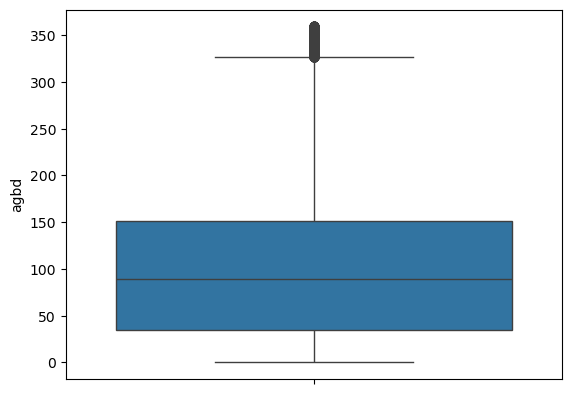

In [96]:
import seaborn as sns
sns.boxplot(gedi04a_wgs84_clean['agbd'])

## GEDI l2a

In [118]:
parms

{'poly': [{'lon': -54.73122618328942, 'lat': -29.960202716109542},
  {'lon': -54.72540366647847, 'lat': -29.148323765909694},
  {'lon': -55.650301468704605, 'lat': -29.1401269661835},
  {'lon': -55.66354175700002, 'lat': -29.95173208699999},
  {'lon': -54.73122618328942, 'lat': -29.960202716109542}],
 'degrade_flag': 0,
 'l4_quality_flag': 1,
 'l2_quality_flag': 1}

In [117]:
gedi02a = gedi02ap(parms)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__flattenbatches',
 '__loader__',
 '__name__',
 '__package__',
 '__processing_request',
 '__spec__',
 'earthdata',
 'gedi01b',
 'gedi01bp',
 'gedi02a',
 'gedi02ap',
 'gedi04a',
 'gedi04ap',
 'geopandas',
 'init',
 'logger',
 'logging',
 'numpy',
 'profiles',
 'sliderule',
 'time']